In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autotime

import scarf
scarf.__version__

'0.23.0'

time: 2.5 s (started: 2022-09-12 02:20:17 +02:00)


In [2]:
scarf.fetch_dataset('kang_15K_pbmc_rnaseq', save_path='scarf_datasets')
scarf.fetch_dataset('kang_14K_ifnb-pbmc_rnaseq', save_path='scarf_datasets')

time: 24.7 s (started: 2022-09-12 02:20:20 +02:00)


In [3]:
def scarf_pipeline(in_dir=None, zarr_fn=None, pca_cell_key='I',
                   umap_label='UMAP', feat_key='hvgs', n_cluster=20):
    if in_dir is not None:
        zarr_fn = in_dir + '/data.zarr'
        reader = scarf.CrDirReader(in_dir, 'rna')
        scarf.CrToZarr(reader, zarr_fn=zarr_fn, chunk_size=(2000, 2000)).dump(batch_size=4000)
    if zarr_fn is None:
        raise ValueError("Please provide a Zarr file")
    ds = scarf.DataStore(zarr_fn, nthreads=8)
    ds.filter_cells(attrs=['RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito'], highs=[6000, 1500, 1], lows=[500, 100, 0])
    ds.filter_cells(attrs=['RNA_nCounts'], highs=[None], lows=[1000])
    ds.mark_hvgs(min_cells=10, top_n=2000)
    ds.make_graph(feat_key=feat_key, k=11, dims=25, n_centroids=100,
                  log_transform=True, renormalize_subset=True, pca_cell_key=pca_cell_key)
    ds.run_leiden_clustering(resolution=2)
    ds.run_umap(n_epochs=250, min_dist=0.5, label=umap_label)
    return ds

time: 0 ns (started: 2022-09-12 02:20:44 +02:00)


  0%|                                                                                                         …

(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing nCounts:   0%|                                                                                …

(RNA) Computing nFeatures:   0%|                                                                              …

(RNA) Computing RNA_percentMito:   0%|                                                                        …

(RNA) Computing RNA_percentRibo:   0%|                                                                        …

INFO: 37 cells flagged for filtering out using attribute RNA_nCounts
INFO: 152 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 3436 cells flagged for filtering out using attribute RNA_percentMito
INFO: 4215 cells flagged for filtering out using attribute RNA_nCounts


(RNA) Computing nCells:   0%|                                                                                 …

(RNA) Computing normed_tot:   0%|                                                                             …

(RNA) Computing sigmas:   0%|                                                                                 …

INFO: 2000 genes marked as HVGs


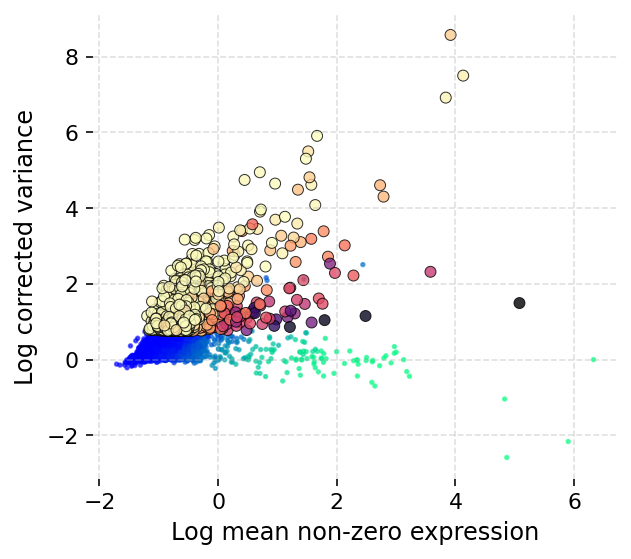

Normalizing with feature subset:   0%|                                                                        …

Writing data to normed__I__hvgs/data:   0%|                                                                   …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.92%


Training UMAP:   0%|                                                                                          …

time: 2min 13s (started: 2022-09-12 02:20:44 +02:00)


In [4]:
# Control PBMC data
ds_ctrl = scarf_pipeline(in_dir='scarf_datasets/kang_15K_pbmc_rnaseq')

Finding markers:   0%|                                                                                        …

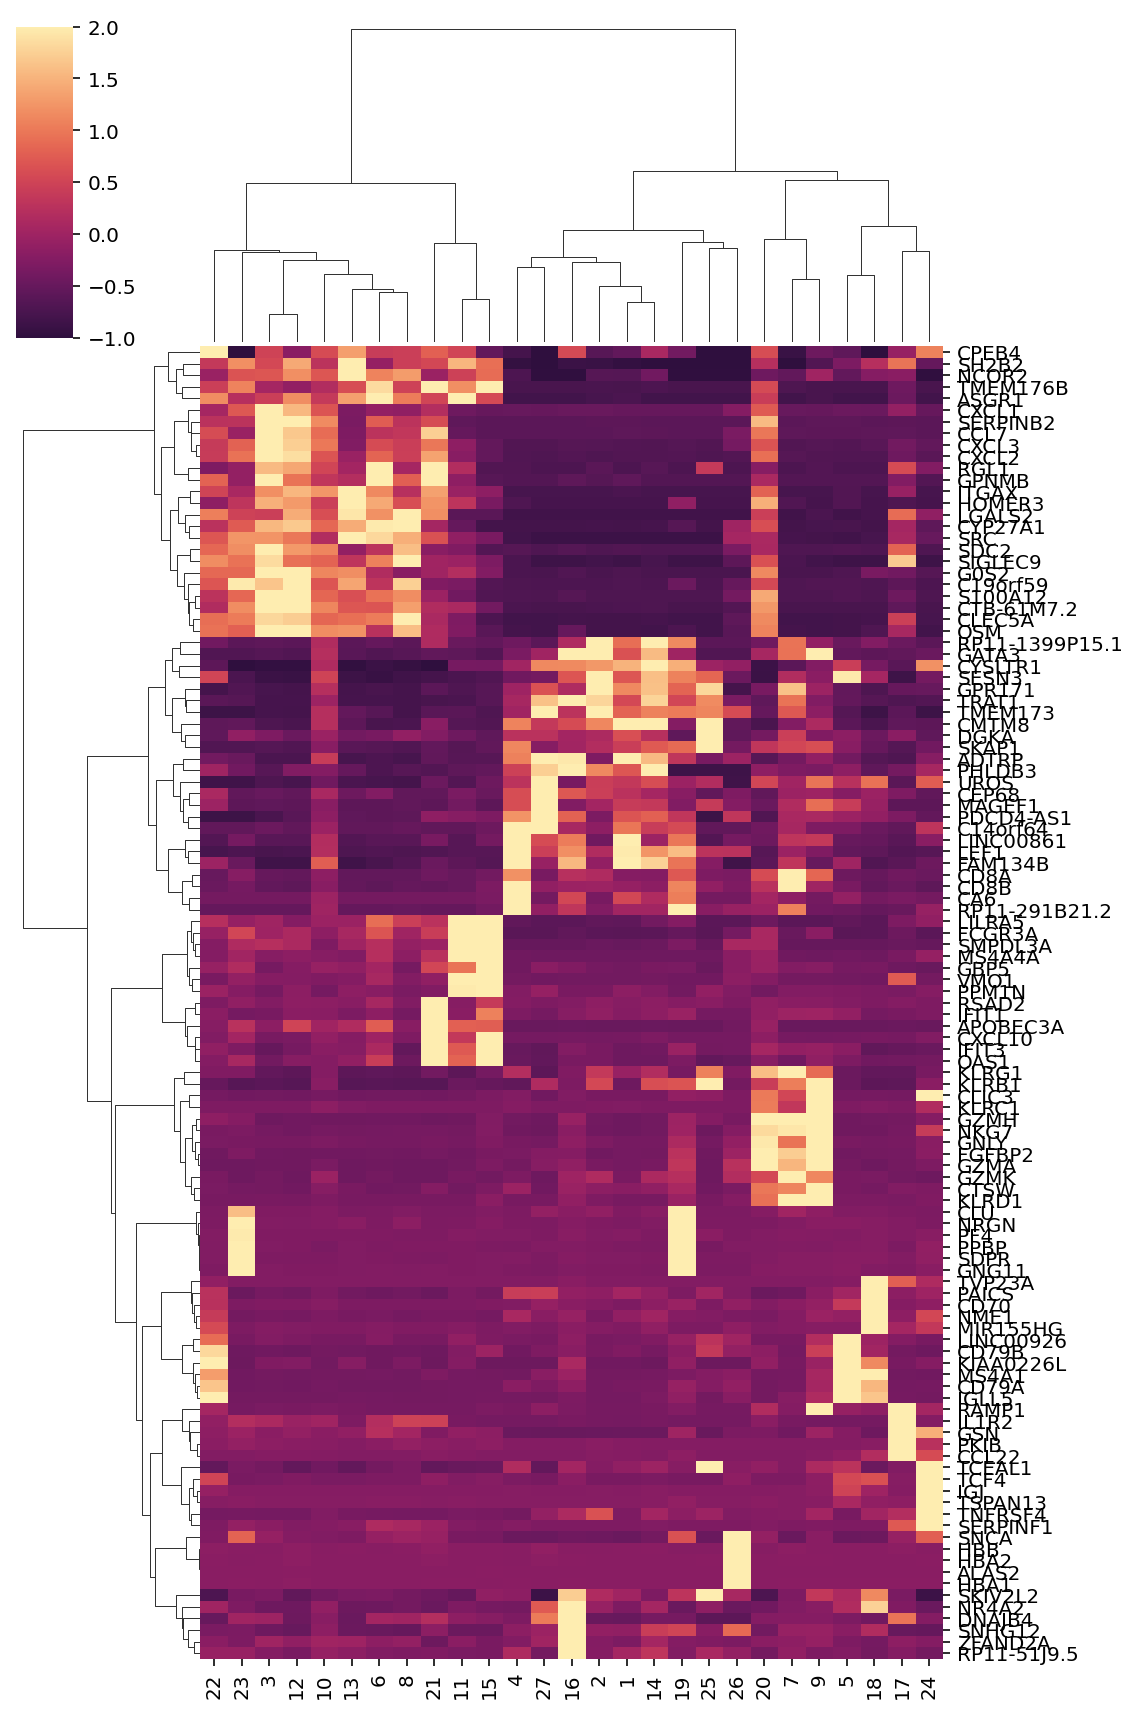

time: 1min 25s (started: 2022-09-12 02:22:58 +02:00)


In [5]:
ds_ctrl.run_marker_search(group_key='RNA_leiden_cluster')
ds_ctrl.plot_marker_heatmap(group_key='RNA_leiden_cluster', topn=5, figsize=(8,12))

In [6]:
ctrl_cluster_labels = {
    19: 'CD4 naive T', 3: 'CD4 naive T', 2: 'CD4 naive T', 24: 'CD4 naive T',
    1: 'CD4 Memory T', 14: 'T activated', 7: 'CD8 T', 12: 'NK',
    5: 'B', 16: 'B activated', 11: 'CD16 Mono', 8: 'CD16 Mono',
    10: 'CD 14 Mono', 13: 'CD 14 Mono', 20: 'CD 14 Mono', 6: 'CD 14 Mono',
    9: 'CD 14 Mono', 4: 'CD 14 Mono', 18: 'CD 14 Mono',
    15: 'DC', 22: 'pDC', 17: 'Mk', 21: 'Mk', 23: 'Eryth'
}
ds_ctrl.cells.insert('cluster_labels',
                     [ctrl_cluster_labels[x] for x in ds_ctrl.cells.fetch('RNA_leiden_cluster')],
                     overwrite=True)
ds_ctrl.plot_layout(layout_key='RNA_UMAP', color_by='cluster_labels',
                    save_dpi=300)

KeyError: 25

time: 515 ms (started: 2022-09-12 02:24:23 +02:00)


In [ ]:
# Interferon beta stimulated PBMC data
ds_stim = scarf_pipeline(in_dir='scarf_datasets/kang_14K_ifnb-pbmc_rnaseq')

In [ ]:
ds_stim.run_marker_search(group_key='RNA_leiden_cluster')
ds_stim.plot_marker_heatmap(group_key='RNA_leiden_cluster', topn=5, figsize=(8,12))

In [ ]:
stim_cluster_labels = {
    24: 'CD4 naive T', 23: 'CD4 naive T', 19: 'CD4 naive T',
    5: 'CD4 naive T', 2: 'CD4 naive T', 14: 'CD4 naive T',
    1: 'CD4 Memory T', 13: 'T activated', 6: 'CD8 T', 11: 'NK',
    4: 'B', 16: 'B activated', 10: 'CD16 Mono', 9: 'CD16 Mono',
    3: 'CD 14 Mono', 7: 'CD 14 Mono', 8: 'CD 14 Mono', 12: 'CD 14 Mono',
    22: 'CD 14 Mono', 18: 'CD 14 Mono',
    15: 'DC', 21: 'pDC', 17: 'Mk', 22: 'Mk', 20: 'Eryth'
}
ds_stim.cells.insert('cluster_labels',
                     [stim_cluster_labels[x] for x in ds_stim.cells.fetch('RNA_leiden_cluster')],
                     overwrite=True)
ds_stim.plot_layout(layout_key='RNA_UMAP', color_by='cluster_labels', save_dpi=300)